#### Assignment-8 LSTM Stock Predictions

#### Poojitha Venkatram

#### https://github.com/poojithavenkatram/Deep-Learning

#### Importing and Loading the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable

# Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/Google_Stock_Price_Train.csv', parse_dates=['Date'], index_col='Date')
print('Number of rows and columns:', data.shape)
data.head()

Number of rows and columns: (1258, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


### Preprocessing Data

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


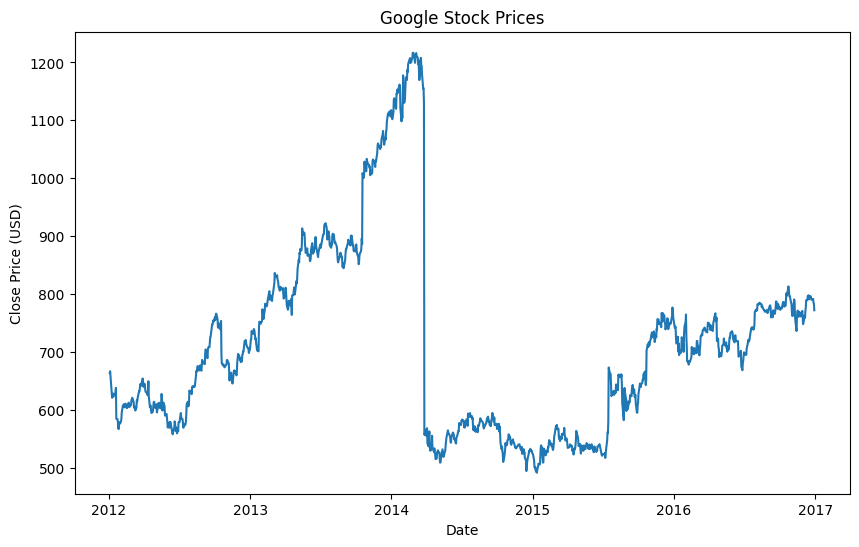

In [3]:
import matplotlib.pyplot as plt

# Check for missing values
print(data.isna().sum())

data['Close'] = data['Close'].astype(str).str.replace(',', '').astype(float)

# Plotting the 'Close' price to see the trend
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.title('Google Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.show()

### Splitting the data into 80% train 20% testing

In [14]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 60  # Number of days to consider for predicting the next day's price
X, y = create_sequences(scaled_prices, sequence_length)

# Splitting the data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print the shapes of the training and test datasets
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training features shape: (958, 60, 1)
Training labels shape: (958, 1)
Test features shape: (240, 60, 1)
Test labels shape: (240, 1)


### Train the model on the data

In [16]:
import torch
import torch.nn as nn

class GoogleStockPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Instantiating the model, defining the loss function and the optimizer
model = GoogleStockPredictor()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for i in range(epochs):
    avg_loss = 0.0
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(torch.FloatTensor(seq))

        single_loss = loss_function(y_pred, torch.FloatTensor(labels))
        avg_loss += single_loss.item()

        single_loss.backward()
        optimizer.step()

    if (i + 1) % 5 == 0:
        print(f'Epoch: {i+1}, Avg. Loss: {avg_loss/len(X_train):.8f}')

Epoch: 5, Avg. Loss: 0.00535873
Epoch: 10, Avg. Loss: 0.00143647
Epoch: 15, Avg. Loss: 0.00117768
Epoch: 20, Avg. Loss: 0.00101181
Epoch: 25, Avg. Loss: 0.00100274
Epoch: 30, Avg. Loss: 0.00101756
Epoch: 35, Avg. Loss: 0.00099529
Epoch: 40, Avg. Loss: 0.00099844
Epoch: 45, Avg. Loss: 0.00095151
Epoch: 50, Avg. Loss: 0.00091582


### Evaluation and Results

MSE is: 0.0009495897549593256


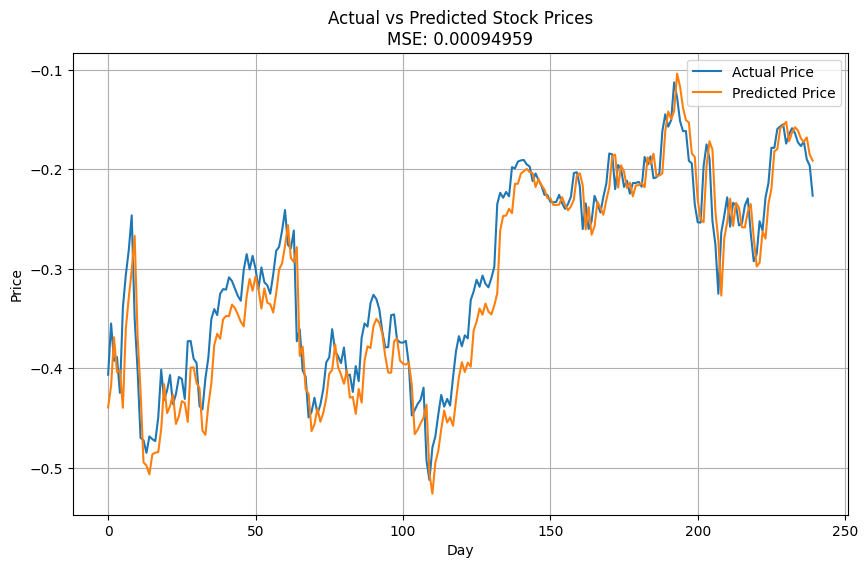

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Evaluation Mode
model.eval()

# Lists to store predictions and actual values
test_predictions = []
with torch.no_grad():
    for seq in X_test:
        test_predictions.append(model(torch.FloatTensor(seq)).item())

# Predictions and actual values
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculating the Mean Squared Error (MSE)
mse = mean_squared_error(actual_prices, test_predictions)
print(f"MSE is: {mse}")

# Visualizing the Results
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(test_predictions, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices\nMSE: {:.8f}'.format(mse))
plt.legend()
plt.grid(True)
plt.show()

### Report on the Results

#### Training Progress: The model was trained for 50 epochs, with the average loss steadily decreasing over the epochs. This indicates that the model is learning and improving its predictions over time. The decrease in the average loss indicates that the model is becoming more accurate in predicting the stock prices.

#### Model Evaluation (MSE): The Mean Squared Error (MSE) is a measure of the average squared difference between the actual and predicted values. A lower MSE indicates better performance of the model. In this case, the MSE is 0.0009495897549593256, which suggests that, on average, the squared difference between the actual and predicted stock prices is relatively very small.

#### Visualization: The actual vs predicted results are visualized in the graph. By comparing the actual prices with the predicted prices, we can assess the accuracy of the model's predictions. The graph clearly shows that the predicted prices closely follow the actual prices, indicating that the model predicts well. This close alignment between the actual and predicted prices suggests that the model is making accurate predictions, capturing the underlying patterns in the stock price data effectively.

#### Thus, the model training shows promising results, with decreasing loss over time indicating improved prediction ability. The low MSE value further supports that the model is generating accurate stock price predictions. This accuracy is visually confirmed by the graph, where predicted prices closely track the actual prices.  Overall, the model appears to be learning effectively, offering the potential for valuable insights into stock market trends.